In [1]:
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
import matplotlib.pyplot as plt
import json 
import collections
import astropy

In [2]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [3]:
from astropy.io import fits

In [4]:
data = Table(fits.open("asu.fit")[1].data)

In [5]:
info = data["_RAJ2000", "_DEJ2000", "WiseID"]

In [6]:
info.to_pandas().to_csv("radecid.csv", index = False)

In [7]:
gaia_data = Table(fits.open("1634333877715O-result.fits")[1].data)

In [8]:
gaia_data_good = gaia_data[np.where((gaia_data["parallax"] > 0) & (np.isnan(gaia_data["bp_rp"]) == False) & (gaia_data["phot_g_mean_mag"] < 16.5))]

In [9]:
distance = 1/(gaia_data_good["parallax"]/1000)
absolute_M = gaia_data_good["phot_g_mean_mag"] - 5 * np.log10(distance)

Text(0.5, 1.0, 'HR Diagram of the stars in M67')

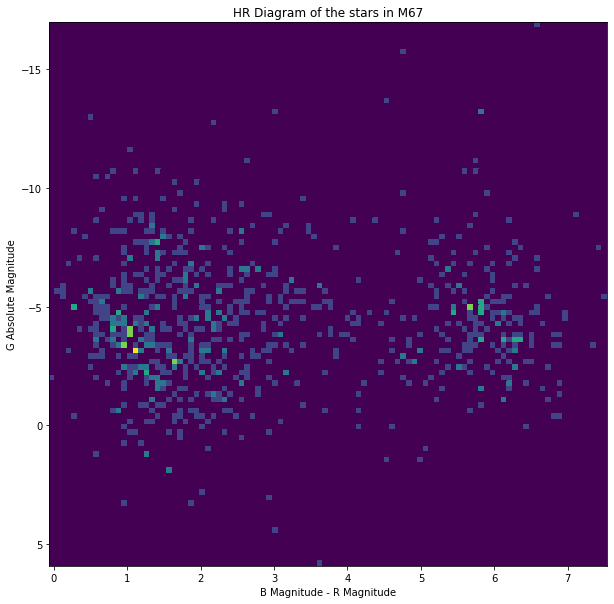

In [10]:
fig, ax = plt.subplots(figsize = (10,10))
ax.hist2d(gaia_data_good["bp_rp"], absolute_M, bins = 100)
ax.invert_yaxis()
plt.ylabel("G Absolute Magnitude")
plt.xlabel("B Magnitude - R Magnitude")
plt.title("HR Diagram of the stars in M67")

In [11]:
best_options = gaia_data_good[np.where((absolute_M < -4))]

In [12]:
best_options.rename_column('wiseid', 'WiseID')

In [13]:
joined = astropy.table.join(data, best_options)

In [14]:
locations = joined["WiseID", "source_id", "ra", "dec"]

In [15]:
utcoffset = -7*u.hour

In [16]:
c = SkyCoord(ra = joined["ra"], dec = joined["dec"], frame="icrs", unit="deg")

In [17]:
palomar = astropy.coordinates.EarthLocation.of_site("palomar")

In [18]:
time = Time('2021-10-22 23:00:00') - utcoffset

In [19]:
c_altaz = c.transform_to(AltAz(obstime = time, location = palomar))

In [20]:
airmass = c_altaz.secz

In [21]:
airmass_np = np.array(airmass)

In [22]:
alt = np.array(c_altaz.alt)
az = np.array(c_altaz.az)

In [23]:
joined["airmass"] = airmass_np
joined["alt"] = alt
joined["az"] = az

In [24]:
moon = astropy.coordinates.get_moon(time = time, location = palomar)

In [25]:
moon_altaz = moon.transform_to(AltAz(obstime = time, location = palomar))

In [26]:
moon_altaz

<SkyCoord (AltAz: obstime=2021-10-23 06:00:00.000, location=(-2410346.78217658, -4758666.82504051, 3487942.97502457) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt, distance) in (deg, deg, m)
    (92.95808116, 41.45915347, 4.00482372e+08)>

In [27]:
moon_sep = np.array(moon_altaz.separation(c_altaz))

In [28]:
joined["moon_sep"] = moon_sep

(array([25., 15.,  8.,  8., 11.,  9., 10.,  4.,  2.,  1.]),
 array([1.02767273, 1.22420422, 1.4207357 , 1.61726719, 1.81379868,
        2.01033017, 2.20686165, 2.40339314, 2.59992463, 2.79645612,
        2.9929876 ]),
 <BarContainer object of 10 artists>)

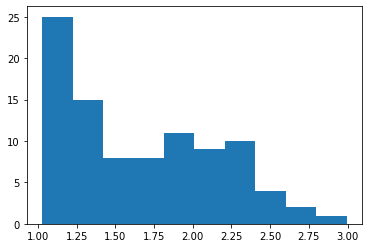

In [40]:
visible = joined[np.where((joined["airmass"] > 1) & (joined["airmass"] < 3) & (joined["moon_sep"] > 20))]
plt.hist(visible["airmass"])

In [41]:
visible.to_pandas().to_csv("visible.csv")

In [42]:
np.unique(visible["SType"])

""
*
*iA
Ae*
Be*
C*
Em*
IR
LP*
Mi*
RV*


In [44]:
visible["ra", "dec"]

ra,dec
float64,float64
2.1755100290452916,63.009350314872854
4.704317800991182,58.62286894622674
4.794283260095182,52.03424331503062
7.338255698779419,64.81405828931211
11.617747391908509,58.90579488512996
12.093001394512248,74.29927798726271
12.448067361917566,63.63612090023577
12.866991529986613,64.94769879878487
16.250455137088746,-5.667735483341909
